In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
# !python3 --version
# !pip --version

# References:
# https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5


# UNCOMMENT THE BELOW IMPORTS IF YOU ARE NOT USING THE COLAB GPU OR IF YOU GET IMPORT ERRORS

# !pip3 install re 
# !pip3 install matplotlib 
# !pip3 install numpy 
# !pip3 install pandas 
# !pip3 install scikit-learn 
# !pip3 install nltk 
!pip3 install seaborn


In [2]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
nltk.download('stopwords')
print('Stopwords have finished downloading successfully')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
print('All imports were successful')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Stopwords have finished downloading successfully
All imports were successful


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# df = pd.read_csv("./train.csv", encoding = "ISO-8859-1")
df = pd.read_csv("/content/train.csv", encoding = "ISO-8859-1")
print('The first 5 elements in the train.csv are:')
print(df.head())

# Getting the number of comments in each category
df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
print(df_stats)

The first 5 elements in the train.csv are:
                 id  ... identity_hate
0  0000997932d777bf  ...             0
1  000103f0d9cfb60f  ...             0
2  000113f07ec002fd  ...             0
3  0001b41b1c6bb37e  ...             0
4  0001d958c54c6e35  ...             0

[5 rows x 8 columns]
        category  number_of_comments
0          toxic               15294
1   severe_toxic                1595
2        obscene                8449
3         threat                 478
4         insult                7877
5  identity_hate                1405


Text(0.5, 0, 'Category')

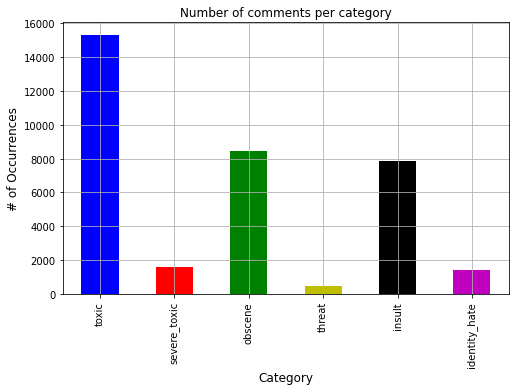

In [4]:
# Getting a histogram of the categories
my_colors = ['b', 'r', 'g', 'y', 'k', 'm']
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5), color=my_colors)

plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
# plt.show()

Text(0.5, 0, '# of Categories')

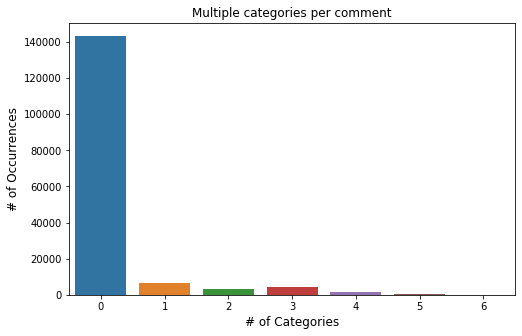

In [5]:
# How many comments have multi-labels?
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of Categories', fontsize=12)

In [6]:
# How many comments are unlabeled
print('Percentage of comments that are not labelled:')
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))


Percentage of comments that are not labelled:
0.8983211235124177


In [7]:
# Function for cleaning the comment text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

# Use the helper function to clean the text
df['comment_text'] = df['comment_text'].map(lambda comment : clean_text(comment))
# print(df['comment_text'][0])

# Splitting the data into train and test sets
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
print('train shape is', X_train.shape)
print('test shape is', X_test.shape)

train shape is (106912,)
test shape is (52659,)


In [8]:
# from sklearn.utils.class_weight import compute_class_weight
# class_weights = compute_class_weight('balanced', np.unique(test), test)

# Define a pipeline combining a text feature extractor with multi lable classifier
# 1. Naive Bayes Pipeline
#    This is essentially a Naive Bayes, but we pass the NB model into a OneVsRestClassifier,
#    which is one of the methods we can use for datasets with multiple labels
print('Training Naive Bayes Pipeline\n')
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('--------- Training {} ---------\n'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print(classification_report(test[category], prediction, labels=np.unique(test[category])))
#     print(prediction.head())
#     print(prediction)

Training Naive Bayes Pipeline

--------- Training toxic ---------

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     47576
           1       0.99      0.16      0.28      5083

    accuracy                           0.92     52659
   macro avg       0.95      0.58      0.62     52659
weighted avg       0.93      0.92      0.89     52659

--------- Training severe_toxic ---------



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     52133
           1       0.00      0.00      0.00       526

    accuracy                           0.99     52659
   macro avg       0.50      0.50      0.50     52659
weighted avg       0.98      0.99      0.99     52659

--------- Training obscene ---------

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     49828
           1       0.99      0.10      0.18      2831

    accuracy                           0.95     52659
   macro avg       0.97      0.55      0.58     52659
weighted avg       0.95      0.95      0.93     52659

--------- Training threat ---------



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52507
           1       0.00      0.00      0.00       152

    accuracy                           1.00     52659
   macro avg       0.50      0.50      0.50     52659
weighted avg       0.99      1.00      1.00     52659

--------- Training insult ---------

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     50016
           1       0.98      0.04      0.07      2643

    accuracy                           0.95     52659
   macro avg       0.97      0.52      0.53     52659
weighted avg       0.95      0.95      0.93     52659

--------- Training identity_hate ---------

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     52188
           1       0.00      0.00      0.00       471

    accuracy                           0.99     52659
   macro avg       0.50      0.50      0.50    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
# Linear SVC
#    This is essentially an SVM, but we pass the SVM into a OneVsRestClassifier,
#    which is one of the methods we can use for datasets with multiple labels
print('Training Linear SVC Pipeline\n')
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter = 400, class_weight='balanced'), n_jobs=1)),
            ])
for category in categories:
    print('--------- Training {} ---------\n'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
#     print('... ... Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print(classification_report(test[category], prediction, labels=np.unique(test[category])))


Training Linear SVC Pipeline

--------- Training toxic ---------

              precision    recall  f1-score   support

           0       0.98      0.97      0.97     47576
           1       0.71      0.80      0.75      5083

    accuracy                           0.95     52659
   macro avg       0.84      0.88      0.86     52659
weighted avg       0.95      0.95      0.95     52659

--------- Training severe_toxic ---------



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     52133
           1       0.33      0.61      0.43       526

    accuracy                           0.98     52659
   macro avg       0.66      0.80      0.71     52659
weighted avg       0.99      0.98      0.99     52659

--------- Training obscene ---------

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     49828
           1       0.76      0.82      0.79      2831

    accuracy                           0.98     52659
   macro avg       0.88      0.90      0.89     52659
weighted avg       0.98      0.98      0.98     52659

--------- Training threat ---------



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     52507
           1       0.41      0.47      0.44       152

    accuracy                           1.00     52659
   macro avg       0.70      0.74      0.72     52659
weighted avg       1.00      1.00      1.00     52659

--------- Training insult ---------

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     50016
           1       0.62      0.76      0.69      2643

    accuracy                           0.97     52659
   macro avg       0.81      0.87      0.83     52659
weighted avg       0.97      0.97      0.97     52659

--------- Training identity_hate ---------



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     52188
           1       0.39      0.54      0.45       471

    accuracy                           0.99     52659
   macro avg       0.69      0.76      0.72     52659
weighted avg       0.99      0.99      0.99     52659



In [10]:
# Logistic Regression Pipeline
#    This is essentially a Logistic Regression model, but we pass the Logistic Regression into a OneVsRestClassifier,
#    which is one of the methods we can use for datasets with multiple labels
print('Training Logistic Regression Pipeline\n')
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(max_iter = 400, solver='sag', class_weight='balanced'), n_jobs=1)),
            ])
for category in categories:
    print('--------- Training {} ---------\n'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print(classification_report(test[category], prediction, labels=np.unique(test[category])))


Training Logistic Regression Pipeline

--------- Training toxic ---------

              precision    recall  f1-score   support

           0       0.98      0.95      0.97     47576
           1       0.66      0.85      0.74      5083

    accuracy                           0.94     52659
   macro avg       0.82      0.90      0.85     52659
weighted avg       0.95      0.94      0.95     52659

--------- Training severe_toxic ---------



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       1.00      0.95      0.97     52133
           1       0.14      0.87      0.25       526

    accuracy                           0.95     52659
   macro avg       0.57      0.91      0.61     52659
weighted avg       0.99      0.95      0.97     52659

--------- Training obscene ---------



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.99      0.98      0.99     49828
           1       0.71      0.86      0.78      2831

    accuracy                           0.97     52659
   macro avg       0.85      0.92      0.88     52659
weighted avg       0.98      0.97      0.97     52659

--------- Training threat ---------



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       1.00      0.93      0.97     52507
           1       0.04      0.86      0.07       152

    accuracy                           0.93     52659
   macro avg       0.52      0.89      0.52     52659
weighted avg       1.00      0.93      0.96     52659

--------- Training insult ---------



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     50016
           1       0.56      0.84      0.67      2643

    accuracy                           0.96     52659
   macro avg       0.78      0.90      0.83     52659
weighted avg       0.97      0.96      0.96     52659

--------- Training identity_hate ---------



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


              precision    recall  f1-score   support

           0       1.00      0.92      0.96     52188
           1       0.08      0.85      0.15       471

    accuracy                           0.92     52659
   macro avg       0.54      0.88      0.55     52659
weighted avg       0.99      0.92      0.95     52659

